# Claira Project: Mortgage Contracts

## Import Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import string
import numpy as np
import gzip
import seaborn as sns
np.random.seed(99)
RANDOM_STATE = 99
import datetime
pd.set_option('display.max_rows', 151)


# Import vectorizing and modeling tools in preparation for modeling steps
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction import text, stop_words
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
import time

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import spacy
import en_core_web_lg
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve, auc

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


## Import Data

In [2]:
# Import the CSV file
# raw_df = pd.read_csv('../data/sasb_cash_trap_triggers.csv')

In [3]:
# Import the CSV file
raw_df = pd.read_csv('../data/sasb_cash_trap_triggers_06_02_20.csv')

In [4]:
# Review the first few rows of the data set
raw_df.head()

,Document,Sentence,Trigger,Multiclass
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",Loan Default,0
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Aggregate DSCR Fall,1
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Loan Default,1
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,Loan Default,0
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,Loan Default,0


In [5]:
# Check size of the data set
raw_df.shape

(892, 4)

In [6]:
raw_df = raw_df[['Document', 'Sentence', 'Trigger', 'Multiclass']]

In [7]:
# Check for null values
raw_df.isnull().sum()

Document      0
Sentence      0
Trigger       0
Multiclass    0
dtype: int64

In [8]:
raw_df.dropna()
raw_df.shape

(892, 4)

In [9]:
raw_df.head()

,Document,Sentence,Trigger,Multiclass
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",Loan Default,0
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Aggregate DSCR Fall,1
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Loan Default,1
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,Loan Default,0
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,Loan Default,0


## Data Cleaning

In [10]:
# Review number of Trigger types
raw_df['Trigger'].value_counts()

Unspecified                  270
Loan Default                 234
Debt Yield Fall               85
Loan default                  75
Mezzanine Default             39
Tenant Failure                35
Debt yield fall               34
Bankruptcy                    20
DSCR Fall                     18
Operator Termination          17
Sponsor Termination           14
Aggregate Debt Yield Fall     11
Mezzanine Outstanding         10
Renovations                    9
Mezzanine default              8
Aggregate debt yield fall      6
Debt Yield Falll               4
Aggregate DSCR Fall            2
Aggregate debt yield           1
Name: Trigger, dtype: int64

In [11]:
# Convert each category to Title format (to remove discrepancies based on capitalization)
raw_df['Trigger'] = raw_df['Trigger'].str.title()

In [12]:
# Review clean Trigger Types
raw_df['Trigger'].value_counts()

Loan Default                 309
Unspecified                  270
Debt Yield Fall              119
Mezzanine Default             47
Tenant Failure                35
Bankruptcy                    20
Dscr Fall                     18
Operator Termination          17
Aggregate Debt Yield Fall     17
Sponsor Termination           14
Mezzanine Outstanding         10
Renovations                    9
Debt Yield Falll               4
Aggregate Dscr Fall            2
Aggregate Debt Yield           1
Name: Trigger, dtype: int64

In [13]:
raw_df['Trigger'] = raw_df['Trigger'].str.replace('Falll', 'Fall')

In [14]:
raw_df.loc[raw_df['Trigger'] == 'Aggregate Debt Yield', 'Trigger'] = 'Aggregate Debt Yield Fall'

In [15]:
# Rename first column (document title)
# raw_df = raw_df.rename(columns = {'0': 'Document'})

In [16]:
# Drop Multiclass column for now 
raw_df = raw_df.drop('Multiclass', axis = 1)
raw_df.head()

,Document,Sentence,Trigger
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",Loan Default
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Aggregate Dscr Fall
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Loan Default
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,Loan Default
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,Loan Default


In [17]:
raw_df.shape

(892, 3)

In [18]:
# Count the number of distinct documents
num_docs = raw_df['Document'].nunique()
print(f'{num_docs} unique documents have been included in the data set')

20 unique documents have been included in the data set


In [19]:
# Review the distinct documents and the number of Trigger events identified for each
raw_df['Document'].value_counts()

20190131_02IFE7_Prospectus_SD000000002578234792.pdf    67
20190131_02IFDN_Prospectus_SD000000002578234912.pdf    66
20181231_02IEP9_Prospectus_SD000000002568455603.pdf    65
20190131_02IFCW_Prospectus_SD000000002578232050.pdf    64
20190220_02IPLU_Prospectus_SD000000002587491183.pdf    63
20190108_02IFF1_Prospectus_SD000000002570458466.pdf    60
20190208_02IM7M_Prospectus_SD000000002581684036.pdf    54
20190205_02IJ77_Prospectus_SD000000002579874729.pdf    50
20160510_02B0XU_Prospectus_SD000000002312723382.pdf    46
20180125_02FE6L_Prospectus_SD000000002394837596.pdf    44
20170525_02DG4Z_Prospectus_SD000000002352418696.pdf    42
20170525_02DFUI_Prospectus_SD000000002352389122.pdf    37
20170727_02DTVX_Prospectus_SD000000002362015714.pdf    35
20171019_02EFSE_Prospectus_SD000000002376978886.pdf    35
20170814_02E227_Prospectus_SD000000002367167139.pdf    34
20150307_028S2X_Prospectus_SD000000002389024187.pdf    29
20170616_02DNAM_Prospectus_SD000000002355931744.pdf    28
20170801_02DX5

In [20]:
# Summarize the trigger counts for the existing Document set
max_triggers = raw_df['Document'].value_counts().max()
min_triggers = raw_df['Document'].value_counts().min()
print(f'The {num_docs} Documents have trigger counts that range from {min_triggers} to {max_triggers}.')

The 20 Documents have trigger counts that range from 20 to 67.


In [21]:
# Check for duplicate rows
raw_df['is_duplicate'] = raw_df.duplicated(subset = None)
raw_df['is_duplicate'].value_counts()

False    844
True      48
Name: is_duplicate, dtype: int64

In [22]:
num_duplicated_rows = (raw_df['is_duplicate'] == True).sum()
print(f'There are {num_duplicated_rows} row duplicates in the data set.')

There are 48 row duplicates in the data set.


In [23]:
# We'll remove the extra duplicate rows
raw_df = raw_df.drop('is_duplicate', axis = 1)
raw_df = raw_df.drop_duplicates()

In [24]:
raw_df.shape

(844, 3)

In [25]:
raw_df.head()

,Document,Sentence,Trigger
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",Loan Default
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Aggregate Dscr Fall
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Loan Default
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,Loan Default
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,Loan Default


In [26]:
# Review new number of Trigger types
raw_df['Trigger'].value_counts()

Loan Default                 297
Unspecified                  261
Debt Yield Fall              110
Mezzanine Default             42
Tenant Failure                35
Aggregate Debt Yield Fall     18
Bankruptcy                    17
Dscr Fall                     16
Operator Termination          15
Sponsor Termination           14
Renovations                    9
Mezzanine Outstanding          8
Aggregate Dscr Fall            2
Name: Trigger, dtype: int64

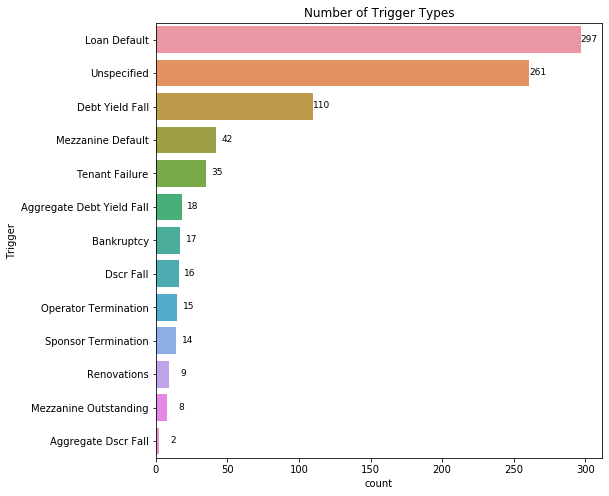

In [27]:
trigger_order = raw_df['Trigger'].value_counts().sort_values(ascending = False).index

fig = plt.gcf()
fig.set_size_inches(8, 8)
ax = sns.countplot(y=raw_df['Trigger'], data=raw_df, orient = 'h', order = trigger_order)
ax.set_title('Number of Trigger Types');

for p in ax.patches:
    ax.annotate(int(p.get_width()),((p.get_x() + p.get_width()), p.get_y()), xytext=(17, -15),fontsize=9,textcoords='offset points', horizontalalignment='right')
    
#https://stackoverflow.com/questions/50190409/how-to-annotate-horizontal-seaborn-countplots

In [28]:
# Review new distinct documents and the number of Trigger events identified for each
raw_df['Document'].value_counts()

20190131_02IFE7_Prospectus_SD000000002578234792.pdf    67
20190131_02IFDN_Prospectus_SD000000002578234912.pdf    66
20181231_02IEP9_Prospectus_SD000000002568455603.pdf    65
20190131_02IFCW_Prospectus_SD000000002578232050.pdf    64
20190220_02IPLU_Prospectus_SD000000002587491183.pdf    62
20190208_02IM7M_Prospectus_SD000000002581684036.pdf    54
20190108_02IFF1_Prospectus_SD000000002570458466.pdf    54
20190205_02IJ77_Prospectus_SD000000002579874729.pdf    50
20160510_02B0XU_Prospectus_SD000000002312723382.pdf    38
20171019_02EFSE_Prospectus_SD000000002376978886.pdf    35
20180125_02FE6L_Prospectus_SD000000002394837596.pdf    34
20170525_02DG4Z_Prospectus_SD000000002352418696.pdf    34
20170525_02DFUI_Prospectus_SD000000002352389122.pdf    33
20170814_02E227_Prospectus_SD000000002367167139.pdf    31
20150307_028S2X_Prospectus_SD000000002389024187.pdf    29
20170616_02DNAM_Prospectus_SD000000002355931744.pdf    28
20170727_02DTVX_Prospectus_SD000000002362015714.pdf    28
20170801_02DX5

In [29]:
raw_df.dtypes

Document    object
Sentence    object
Trigger     object
dtype: object

## Reshape the Data

In this section, we'll reshape the data, such that each sentence is represented once, with separate categorization columns for each Trigger type

In [30]:
# function to reshape the dataframe such that the triggers are 0/1 columns. Remove duplicates
def reshape_trigger_representation(dataframe):
    # select trigger types
    trigger_types = list(dataframe['Trigger'].unique())
    trigger_types = [x for x in trigger_types if str(x) != 'nan']
    
    # create new dataframe with unique document-sentence pairs (no duplicates)
    reshaped = dataframe.drop('Trigger', axis = 1).drop_duplicates().reset_index().drop('index', axis = 1)
    
    # select rows by trigger, reassign as 1 or 0 (for True or False)
    for tt in trigger_types:
        # select part that is trigger_type
        temp = dataframe.loc[dataframe['Trigger'] == tt].copy()

        # create a new column of true with trigger name
        temp[tt.lower().replace(' ', '_')] = np.int64(1)
        temp.drop('Trigger', axis=1, inplace=True)
        temp[tt.lower().replace(' ', '_')] = temp[tt.lower().replace(' ', '_')].astype('Int64')
        
        # left join this adjusted column to the unique data
        reshaped = reshaped.merge(temp, how='left', left_on=['Document', 'Sentence'], right_on=['Document', 'Sentence'])

    # replace nulls with False
    reshaped = reshaped.fillna(0)    
    
    return reshaped

In [31]:
# Reshape our original dataframe
df = reshape_trigger_representation(raw_df)

In [32]:
df.head(5)

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,0,0,0,0,0
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,0,0,0,0,0
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,0,0,0,0,0
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,0,0,0,0,0
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
# Export reshaped to CSV file
# df.to_csv('../data/reshaped_06_02_20.csv')

In [34]:
df.dtypes

Document                     object
Sentence                     object
loan_default                  Int64
aggregate_dscr_fall           Int64
dscr_fall                     Int64
unspecified                   Int64
debt_yield_fall               Int64
aggregate_debt_yield_fall     Int64
mezzanine_default             Int64
tenant_failure                Int64
mezzanine_outstanding         Int64
operator_termination          Int64
bankruptcy                    Int64
sponsor_termination           Int64
renovations                   Int64
dtype: object

In [35]:
df.shape

(686, 15)

In [36]:
# We can confirm that the number of Triggers is consistent with the prior dataframe
df.sum()

Document                     20120828_01Y0R8_Prospectus_CM00000000205875087...
Sentence                     On each Business Day, the financial institutio...
loan_default                                                               297
aggregate_dscr_fall                                                          2
dscr_fall                                                                   16
unspecified                                                                261
debt_yield_fall                                                            110
aggregate_debt_yield_fall                                                   18
mezzanine_default                                                           42
tenant_failure                                                              35
mezzanine_outstanding                                                        8
operator_termination                                                        15
bankruptcy                                          

## Feature Engineering

In [37]:
# Create a column with length of Sentence
df['sentence_char_count'] = df['Sentence'].str.len()

In [38]:
df.head()

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,sentence_char_count
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,0,0,0,0,0,446
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,0,0,0,0,0,836
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,0,0,0,0,0,1772
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,0,0,0,0,0,302
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,0,0,0,0,0,235


## Natural Language Processing of the sentence column

In [39]:
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser'])

In [40]:
# Review a tokenized sample Sentence
[token.text for token in nlp(df['Sentence'][2])]

['During',
 'a',
 'Trigger',
 'Period',
 'or',
 'while',
 'an',
 'event',
 'of',
 'default',
 'under',
 'the',
 'Mortgage',
 'Loan',
 'is',
 'continuing',
 ',',
 'all',
 'amounts',
 'available',
 'in',
 'the',
 'Cash',
 'Management',
 'Account',
 'will',
 'be',
 'applied',
 'on',
 'each',
 'Loan',
 'Payment',
 'Date',
 'in',
 'the',
 'following',
 'order',
 'of',
 'priority',
 ':',
 '(',
 'i',
 ')',
 'to',
 'the',
 'Tax',
 'and',
 'Insurance',
 'Reserve',
 'Account',
 ',',
 '(',
 'a',
 ')',
 '1/12th',
 'of',
 'projected',
 'annual',
 'taxes',
 'and',
 '(',
 'b',
 ')',
 '1/12th',
 'of',
 'projected',
 'annual',
 'insurance',
 'premiums',
 '(',
 'unless',
 'certain',
 'blanket',
 'policies',
 'are',
 'in',
 'effect',
 ')',
 ',',
 '(',
 'ii',
 ')',
 'to',
 'the',
 'lender',
 ',',
 'the',
 'amount',
 'of',
 'all',
 'scheduled',
 'or',
 'delinquent',
 'interest',
 'and',
 'principal',
 'on',
 'the',
 'Mortgage',
 'Loan',
 'and',
 'all',
 'other',
 'amounts',
 'then',
 'due',
 'and',
 'payab

In [41]:
# Review a lemmatized sample Sentence
[token.lemma_ for token in nlp(df['Sentence'][2])]

['during',
 'a',
 'trigger',
 'period',
 'or',
 'while',
 'an',
 'event',
 'of',
 'default',
 'under',
 'the',
 'mortgage',
 'loan',
 'be',
 'continue',
 ',',
 'all',
 'amount',
 'available',
 'in',
 'the',
 'cash',
 'management',
 'account',
 'will',
 'be',
 'apply',
 'on',
 'each',
 'loan',
 'payment',
 'date',
 'in',
 'the',
 'follow',
 'order',
 'of',
 'priority',
 ':',
 '(',
 'i',
 ')',
 'to',
 'the',
 'tax',
 'and',
 'insurance',
 'reserve',
 'account',
 ',',
 '(',
 'a',
 ')',
 '1/12th',
 'of',
 'project',
 'annual',
 'tax',
 'and',
 '(',
 'b',
 ')',
 '1/12th',
 'of',
 'project',
 'annual',
 'insurance',
 'premium',
 '(',
 'unless',
 'certain',
 'blanket',
 'policy',
 'be',
 'in',
 'effect',
 ')',
 ',',
 '(',
 'ii',
 ')',
 'to',
 'the',
 'lender',
 ',',
 'the',
 'amount',
 'of',
 'all',
 'schedule',
 'or',
 'delinquent',
 'interest',
 'and',
 'principal',
 'on',
 'the',
 'mortgage',
 'loan',
 'and',
 'all',
 'other',
 'amount',
 'then',
 'due',
 'and',
 'payable',
 'under',
 'the

In [42]:
def tokenize(text):
    doc = nlp(text)
    tokens = [token.text for token in doc]
    return ' '.join(tokens)

df['SentenceTokens'] = df['Sentence'].apply(tokenize)

In [43]:
def lemmatize(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return ' '.join(lemmas)

df['SentenceLemmas'] = df['Sentence'].apply(lemmatize)

In [44]:
df.head()

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,sentence_char_count,SentenceTokens,SentenceLemmas
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,0,0,0,0,0,446,"On each Business Day , the financial instituti...","on each business day , the financial instituti..."
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,0,0,0,0,0,836,The Borrower has established and is required t...,the borrower have establish and be require to ...
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,0,0,0,0,0,1772,During a Trigger Period or while an event of d...,during a trigger period or while an event of d...
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,0,0,0,0,0,302,On any Business Day all amounts on deposit in ...,on any business day all amount on deposit in t...
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,0,0,0,0,0,235,Available funds in each Cash Management Accoun...,available fund in each cash management account...


In [45]:
# Put all sentences into a list of review tokens
all_sentence_tokens = ' '.join(df['SentenceTokens'])
all_sentence_tokens[:75]

'On each Business Day , the financial institution maintaining the blocked ac'

In [46]:
# Put all sentences into a list of review lemmas
all_sentence_lemmas = ' '.join(df['SentenceLemmas'])
all_sentence_lemmas[:75]

'on each business day , the financial institution maintain the block account'

In [47]:
sentence_token_list = [token for token in all_sentence_tokens.split(' ')]
sentence_lemma_list = [lemma for lemma in all_sentence_lemmas.split(' ')]

In [48]:
token_df = pd.Series(sentence_token_list)
lemma_df = pd.Series(sentence_lemma_list)

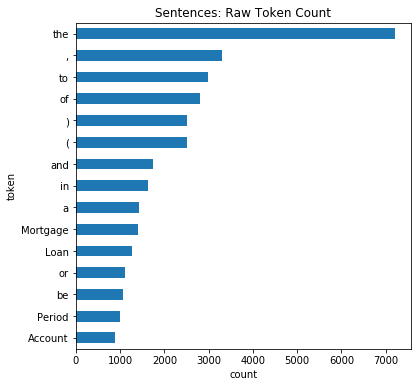

In [49]:
# Plotting the raw token count
token_series = token_df.value_counts().head(15).sort_values(ascending = True)
ax = token_series.plot.barh(figsize = (6,6))
ax.set_xlabel('count')
ax.set_ylabel('token')
ax.set_title('Sentences: Raw Token Count');

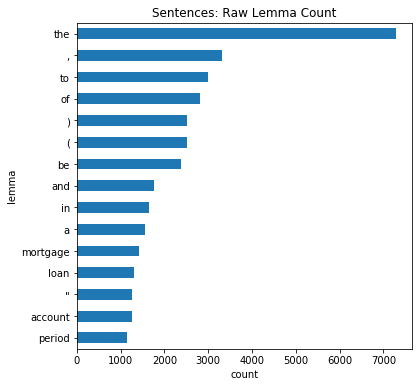

In [50]:
# Plotting the raw lemma count
lemma_series = lemma_df.value_counts().head(15).sort_values(ascending = True)
ax = lemma_series.plot.barh(figsize = (6,6))
ax.set_xlabel('count')
ax.set_ylabel('lemma')
ax.set_title('Sentences: Raw Lemma Count');

In [51]:
# Remove punctuation, maintain letters and numbers
df['SentenceLemmas_nopunc'] = df['SentenceLemmas'].str.replace("[^a-zA-Z0-9#']", " ")

In [52]:
# Put all SentenceLemmas_nopunc into a list
all_lemmas_nopunc = ' '.join(df['SentenceLemmas_nopunc'])
lemma_list_nopunc = [lemma for lemma in all_lemmas_nopunc.split(' ')]
lemma_list_nopunc = [lemma for lemma in lemma_list_nopunc if lemma not in ['']]
lemma_list_nopunc[:10]

['on',
 'each',
 'business',
 'day',
 'the',
 'financial',
 'institution',
 'maintain',
 'the',
 'block']

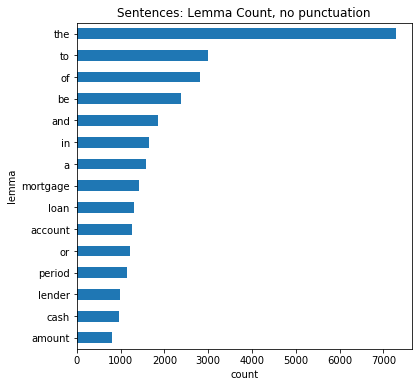

In [53]:
# Create a data series containing the list of words
lemma_df_nopunc = pd.Series(lemma_list_nopunc)
lemma_series_nopunc = lemma_df_nopunc.value_counts().head(15).sort_values(ascending = True)
ax = lemma_series_nopunc.plot.barh(figsize = (6,6))
ax.set_xlabel('count')
ax.set_ylabel('lemma')
ax.set_title('Sentences: Lemma Count, no punctuation');

In [54]:
df['SentenceLemmas_nopunc'].head()

0    on each business day   the financial instituti...
1    the borrower have establish and be require to ...
2    during a trigger period or while an event of d...
3    on any business day all amount on deposit in t...
4    available fund in each cash management account...
Name: SentenceLemmas_nopunc, dtype: object

In [55]:
df['SentenceLemmas_nopunc'] = df['SentenceLemmas_nopunc'].str.replace('\s{2,}', ' ')

In [56]:
df['SentenceLemmas_nopunc'].head()

0    on each business day the financial institution...
1    the borrower have establish and be require to ...
2    during a trigger period or while an event of d...
3    on any business day all amount on deposit in t...
4    available fund in each cash management account...
Name: SentenceLemmas_nopunc, dtype: object

## Preprocessing and Preparation for Modeling

In [57]:
short_stopwords = ['the', 'and', 'a', 'to', 'I', 'it', 'be', 'for', 'with', 'that']

In [58]:
# Look at original stopword list
stopwords = list(STOP_WORDS)
stopwords

['there',
 'might',
 'too',
 'per',
 'had',
 'regarding',
 'another',
 'call',
 'fifteen',
 'whoever',
 'around',
 'sometime',
 'down',
 'toward',
 'was',
 'put',
 'other',
 'none',
 'several',
 'much',
 'everywhere',
 'the',
 'get',
 'will',
 'own',
 'side',
 'since',
 'perhaps',
 'still',
 'becoming',
 'him',
 'something',
 'indeed',
 'together',
 'whence',
 'whereas',
 'just',
 'somehow',
 'about',
 'five',
 'three',
 'are',
 'less',
 'whenever',
 'our',
 'without',
 'nor',
 'ten',
 'anyhow',
 'back',
 'above',
 'them',
 'yourselves',
 'how',
 'upon',
 'and',
 'hundred',
 'using',
 'became',
 'within',
 'anyway',
 'while',
 'nine',
 'otherwise',
 'could',
 'bottom',
 'becomes',
 'namely',
 'also',
 'nothing',
 'please',
 'so',
 'again',
 'amongst',
 'that',
 'to',
 'via',
 'we',
 'whereafter',
 'behind',
 'empty',
 'as',
 'someone',
 'whether',
 'why',
 'anyone',
 'except',
 'many',
 'you',
 'fifty',
 'two',
 'by',
 'always',
 'himself',
 'give',
 'third',
 'whose',
 'nobody',
 'whe

In [59]:
# Choose to exclude anything with numbers are might be particularly relevant
to_exclude = ['thereupon', 'cannot', 'should'] 

In [60]:
# Define our selected stopword lists 
select_stopwords = [word for word in stopwords if word not in to_exclude]
select_stopwords

['there',
 'might',
 'too',
 'per',
 'had',
 'regarding',
 'another',
 'call',
 'fifteen',
 'whoever',
 'around',
 'sometime',
 'down',
 'toward',
 'was',
 'put',
 'other',
 'none',
 'several',
 'much',
 'everywhere',
 'the',
 'get',
 'will',
 'own',
 'side',
 'since',
 'perhaps',
 'still',
 'becoming',
 'him',
 'something',
 'indeed',
 'together',
 'whence',
 'whereas',
 'just',
 'somehow',
 'about',
 'five',
 'three',
 'are',
 'less',
 'whenever',
 'our',
 'without',
 'nor',
 'ten',
 'anyhow',
 'back',
 'above',
 'them',
 'yourselves',
 'how',
 'upon',
 'and',
 'hundred',
 'using',
 'became',
 'within',
 'anyway',
 'while',
 'nine',
 'otherwise',
 'could',
 'bottom',
 'becomes',
 'namely',
 'also',
 'nothing',
 'please',
 'so',
 'again',
 'amongst',
 'that',
 'to',
 'via',
 'we',
 'whereafter',
 'behind',
 'empty',
 'as',
 'someone',
 'whether',
 'why',
 'anyone',
 'except',
 'many',
 'you',
 'fifty',
 'two',
 'by',
 'always',
 'himself',
 'give',
 'third',
 'whose',
 'nobody',
 'whe

## Train/Test Split

In [61]:
df.head()

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,sentence_char_count,SentenceTokens,SentenceLemmas,SentenceLemmas_nopunc
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,0,0,0,0,0,446,"On each Business Day , the financial instituti...","on each business day , the financial instituti...",on each business day the financial institution...
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,0,0,0,0,0,836,The Borrower has established and is required t...,the borrower have establish and be require to ...,the borrower have establish and be require to ...
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,0,0,0,0,0,1772,During a Trigger Period or while an event of d...,during a trigger period or while an event of d...,during a trigger period or while an event of d...
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,0,0,0,0,0,302,On any Business Day all amounts on deposit in ...,on any business day all amount on deposit in t...,on any business day all amount on deposit in t...
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,0,0,0,0,0,235,Available funds in each Cash Management Accoun...,available fund in each cash management account...,available fund in each cash management account...


In [62]:
# Start by predicting Loan Default trigger

target = 'loan_default'


X = df['Sentence']
y = df['unspecified']

y = y.astype('int')

In [63]:
y.dtypes

dtype('int64')

In [64]:
# Checking shape of X and y 
print(f'X shape is {X.shape}')
print(f'y shape is {y.shape}')

X shape is (686,)
y shape is (686,)


In [65]:
y.value_counts()

0    425
1    261
Name: unspecified, dtype: int64

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(514,) (514,)
(172,) (172,)


In [67]:
X.head()

0    On each Business Day, the financial institutio...
1    The Borrower has established and is required t...
2    During a Trigger Period or while an event of d...
3    On any Business Day all amounts on deposit in ...
4    Available funds in each Cash Management Accoun...
Name: Sentence, dtype: object

In [68]:
X_train.shape[0]

514

In [69]:
y_train.shape[0]

514

## Modeling

### CountVectorizer + Logistic Regression GridSearch and modeling

In [70]:
# Define CVEC + Logistic Regression Pipeline
pipe_cvec = Pipeline([('cvec', CountVectorizer()), ('lr', LogisticRegression(solver = 'liblinear', random_state = RANDOM_STATE))])
cvec_params = {
    'cvec__ngram_range': [(1,2), (1,3), (1,4), (1,5), (1,6), (1,7), (1,8), (1,9), (1,10)],
    'cvec__stop_words': [None, short_stopwords, select_stopwords],  
    'cvec__max_features': [100, 200, 400, 600, 800, 1000],
#    'cvec__min_df': [2],
#    'cvec__max_df': [.99],
    }

gs_cvec = GridSearchCV(pipe_cvec, param_grid = cvec_params, cv = 3, scoring = 'accuracy')

# Start the timer.
t0 = time.time()

results_cvec = gs_cvec.fit(X_train, y_train)

print(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.



Seconds elapsed for fitting: 174.404


In [71]:
#log_reg = LogisticRegression()
#logreg.fit(X_train, y_train)


In [72]:
t0 = time.time()
print(f'Training score is {results_cvec.score(X_train, y_train):.3f}')
print(f'Test score is {results_cvec.score(X_test, y_test):.3f}')
print(f'Cross Validation score is {cross_val_score(results_cvec.best_estimator_, X, y, cv = 3).mean():.3f}')
print(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.

Training score is 0.998
Test score is 0.953
Cross Validation score is 0.911
Seconds elapsed for score calculation: 2.254


In [73]:
print(f'Best Score:{(results_cvec.best_score_):.3f}')
print(f'Best Parameters :{results_cvec.best_params_}')

Best Score:0.947
Best Parameters :{'cvec__max_features': 400, 'cvec__ngram_range': (1, 8), 'cvec__stop_words': ['the', 'and', 'a', 'to', 'I', 'it', 'be', 'for', 'with', 'that']}


### 2: TFIDF + Logistic Regression GridSearch and modeling

In [74]:
# Define TFIDF + Logistic Regression Pipeline

pipe_tfidf = Pipeline([('tfidf', TfidfVectorizer()), ('lr', LogisticRegression(max_iter = 4000, random_state = RANDOM_STATE))])

tfidf_params = {
    'tfidf__ngram_range': [(1,2), (1,3), (1,4), (1,5), (1,6), (1,7), (1,8), (1,9), (1,10)],
    'tfidf__stop_words': [None, short_stopwords, select_stopwords],  
    'tfidf__max_features': [100, 200, 400, 600, 800, 1000],
#    'tfidf__min_df': [2],
#    'tfidf__max_df': [.99],
    }

gs_tfidf = GridSearchCV(pipe_tfidf, param_grid = tfidf_params, cv = 3, scoring = 'accuracy')

results_tfidf = gs_tfidf.fit(X_train, y_train)

print(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.



Seconds elapsed for fitting: 186.282


In [75]:
t0 = time.time()
print(f'Training score is {results_tfidf.score(X_train, y_train):.3f}')
print(f'Test score is {results_tfidf.score(X_test, y_test):.3f}')
print(f'Cross Validation score is {cross_val_score(results_tfidf.best_estimator_, X, y, cv = 3).mean():.3f}')
print(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.

Training score is 0.971
Test score is 0.936
Cross Validation score is 0.908
Seconds elapsed for score calculation: 1.185


In [76]:
print(f'Best Score: {results_tfidf.best_score_}')
print(f'Best Parameters: {results_tfidf.best_params_}')

Best Score: 0.9396618160388049
Best Parameters: {'tfidf__max_features': 1000, 'tfidf__ngram_range': (1, 4), 'tfidf__stop_words': ['the', 'and', 'a', 'to', 'I', 'it', 'be', 'for', 'with', 'that']}


### 3: CountVectorizer + Multinomial Naive Bayes GridSearch & modeling

In [77]:
# Define CountVectorizer + Multinomial Naive Bayes Grisearch pipeline

pipe_mnb = Pipeline([('cvec', CountVectorizer()), ('mnb', MultinomialNB())])
mnb_params = {
    'cvec__ngram_range': [(1,2), (1,3), (1,4), (1,5), (1,6), (1,7), (1,8), (1,9), (1,10)],
    'cvec__stop_words': [None, short_stopwords, select_stopwords],
    'cvec__max_features': [100, 200, 400, 600, 800, 1000],
#    'cvec__min_df': [3],
#    'cvec__max_df': [ .99],
    }

gs_mnb = GridSearchCV(pipe_mnb, param_grid = mnb_params, cv = 3, scoring = 'accuracy')

# Start the timer.
t0 = time.time()

results_mnb = gs_mnb.fit(X_train, y_train)

print(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.

Seconds elapsed for fitting: 184.992


In [78]:
t0 = time.time()
print(f'Training score is {results_mnb.score(X_train, y_train):.3f}')
print(f'Test score is {results_mnb.score(X_test, y_test):.3f}')
print(f'Cross Validation score is {cross_val_score(results_mnb.best_estimator_, X, y, cv = 3).mean():.3f}')
print(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.

Training score is 0.936
Test score is 0.924
Cross Validation score is 0.881
Seconds elapsed for score calculation: 1.114


In [79]:
print(f'Best Score: {results_mnb.best_score_}')
print(f'Best Parameters: {results_mnb.best_params_}')

Best Score: 0.9240559408858062
Best Parameters: {'cvec__max_features': 1000, 'cvec__ngram_range': (1, 5), 'cvec__stop_words': ['there', 'might', 'too', 'per', 'had', 'regarding', 'another', 'call', 'fifteen', 'whoever', 'around', 'sometime', 'down', 'toward', 'was', 'put', 'other', 'none', 'several', 'much', 'everywhere', 'the', 'get', 'will', 'own', 'side', 'since', 'perhaps', 'still', 'becoming', 'him', 'something', 'indeed', 'together', 'whence', 'whereas', 'just', 'somehow', 'about', 'five', 'three', 'are', 'less', 'whenever', 'our', 'without', 'nor', 'ten', 'anyhow', 'back', 'above', 'them', 'yourselves', 'how', 'upon', 'and', 'hundred', 'using', 'became', 'within', 'anyway', 'while', 'nine', 'otherwise', 'could', 'bottom', 'becomes', 'namely', 'also', 'nothing', 'please', 'so', 'again', 'amongst', 'that', 'to', 'via', 'we', 'whereafter', 'behind', 'empty', 'as', 'someone', 'whether', 'why', 'anyone', 'except', 'many', 'you', 'fifty', 'two', 'by', 'always', 'himself', 'give', 'thi

### 4: TFIDF + Gaussian Naive Bayes GridSearch & modeling

In [80]:
# Define TFIDF + Gaussian Naive Bayes Gridsearch pipeline

from sklearn.base import TransformerMixin
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()


pipe_gnb = Pipeline([('tfidf', TfidfVectorizer()), ('to_dense', DenseTransformer()),('gnb', GaussianNB())])

gnb_params = {
    'tfidf__ngram_range': [(1,2), (1,3), (1,4), (1,5), (1,6), (1,7), (1,8), (1,9), (1,10)],
    'tfidf__stop_words': [None, short_stopwords, select_stopwords],
    'tfidf__max_features': [100, 200, 400, 600, 800, 1000],
#    'tfidf__min_df': [2],
#    'tfidf__max_df': [.99],
    }

gs_gnb = GridSearchCV(pipe_gnb, param_grid = gnb_params, cv = 3, scoring = 'accuracy')

# Start the timer.
t0 = time.time()

results_gnb = gs_gnb.fit(X_train, y_train)

print(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.

Seconds elapsed for fitting: 187.726


In [81]:
t0 = time.time()
print(f'Training score is {results_gnb.score(X_train, y_train):.3f}')
print(f'Test score is {results_gnb.score(X_test, y_test):.3f}')
print(f'Cross Validation score is {cross_val_score(results_gnb.best_estimator_, X, y, cv = 3).mean():.3f}')
print(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.

Training score is 0.967
Test score is 0.953
Cross Validation score is 0.913
Seconds elapsed for score calculation: 1.487


In [82]:
print(f'Best Score: {results_gnb.best_score_}')
print(f'Best Parameters: {results_gnb.best_params_}')

Best Score: 0.945532435740514
Best Parameters: {'tfidf__max_features': 400, 'tfidf__ngram_range': (1, 5), 'tfidf__stop_words': ['the', 'and', 'a', 'to', 'I', 'it', 'be', 'for', 'with', 'that']}


## Model Selection
- In this section we compare the Train and Test scores across the various models

In [83]:
# Check Training Scores across all models
print(f'Baseline Score:                                {y_test.value_counts(normalize=True)[0]:.3f}')
print(f'CountVectorizer + LogisticRegression Accuracy: {results_cvec.score(X_train, y_train):.3f}')
print(f'TfidfVectorizer + LogisticRegression Accuracy: {results_tfidf.score(X_train, y_train):.3f}')
print(f'CountVectorizer + Multinomial Naive Bayes:     {results_mnb.score(X_train, y_train):.3f}')
print(f'TfidfVectorizer + Gaussian Naive Bayes:        {results_gnb.score(X_train, y_train):.3f}')

Baseline Score:                                0.610
CountVectorizer + LogisticRegression Accuracy: 0.998
TfidfVectorizer + LogisticRegression Accuracy: 0.971
CountVectorizer + Multinomial Naive Bayes:     0.936
TfidfVectorizer + Gaussian Naive Bayes:        0.967


In [84]:
# Check Testing Scores across all models
print(f'Baseline Score:                                {y_test.value_counts(normalize=True)[0]:.3f}')
print(f'CountVectorizer + LogisticRegression Accuracy: {results_cvec.score(X_test, y_test):.3f}')
print(f'TfidfVectorizer + LogisticRegression Accuracy: {results_tfidf.score(X_test, y_test):.3f}')
print(f'CountVectorizer + Multinomial Naive Bayes:     {results_mnb.score(X_test, y_test):.3f}')
print(f'TfidfVectorizer + Gaussian Naive Bayes:        {results_gnb.score(X_test, y_test):.3f}')

Baseline Score:                                0.610
CountVectorizer + LogisticRegression Accuracy: 0.953
TfidfVectorizer + LogisticRegression Accuracy: 0.936
CountVectorizer + Multinomial Naive Bayes:     0.924
TfidfVectorizer + Gaussian Naive Bayes:        0.953


## Model Evaluation

In [85]:
# Isolate the individual words and their coefficients
# Feature names (i.e., words in the Sentences):
names = results_cvec.best_estimator_.steps[0][1].get_feature_names()

# classifier (betas):
classifier = results_cvec.best_estimator_.named_steps['lr']

# https://stackoverflow.com/questions/43856280/return-coefficients-from-pipeline-object-in-sklearn

In [86]:
# Extract coefficients from the classifier defined above
coef_cvec = np.array(classifier.coef_).tolist()[0]
coef_cvec[:10] #Look at 10 coefficients

[0.06591656439185199,
 -0.04677821640793433,
 0.2320587029097714,
 0.36115597632642965,
 -0.0576661739883037,
 -0.0576661739883037,
 0.2019222745149388,
 -0.13410135411597182,
 -0.03434497651578352,
 -0.09444241995092743]

In [87]:
# Create zipped list of the word names with their corresponding beta coefficients
cvec_top_words = list(zip(names, coef_cvec))

In [88]:
# Create final dataframe of words with their corresponding coefficients
df_cvec_coefs = pd.DataFrame(cvec_top_words).rename(columns = {0: 'word', 1: 'coef'}).sort_values(by = 'coef', ascending = True)

In [89]:
# Top differentiating words and phrases for this Trigger type
df_cvec_coefs.tail(20).sort_values('coef', ascending = False)

,word,coef
265,of cash,0.693289
380,trigger period,0.658605
194,is required,0.627216
30,approved,0.578250
307,period borrower,0.536048
83,cure,0.534067
120,during,0.483705
284,on each,0.472242
217,lockbox,0.454808
31,are,0.451592


In [90]:
# Display top opposing words and phrases for this Trigger type
df_cvec_coefs.head(20)

,word,coef
167,hotel,-1.035662
93,default,-1.011180
134,event of default,-0.999424
267,of default,-0.999415
309,period or,-0.991355
133,event of,-0.726916
132,event,-0.718143
251,no,-0.692095
118,due,-0.683921
89,debt,-0.623922


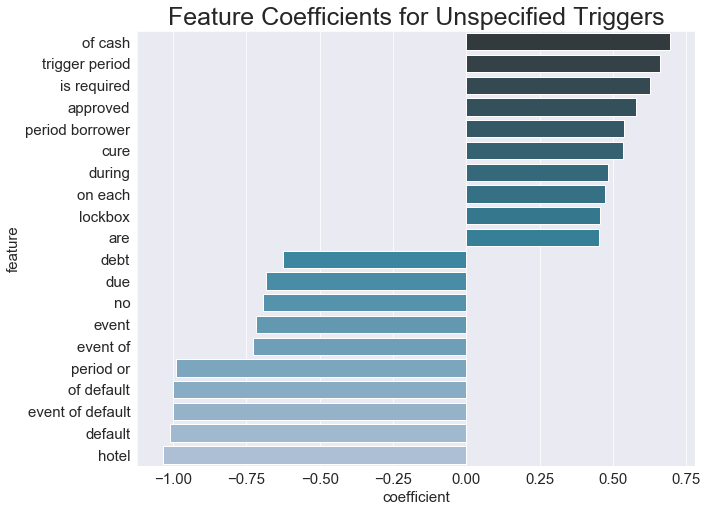

In [104]:
def coef_plot(category):
    '''
    Plots the top 10 and bottom 10 coefficients for the complexity category specified
    '''
    coefs_1 = df_cvec_coefs.sort_values(by=category, ascending=False).tail(10) # getting the top 10 coefficients
    coefs_2 = df_cvec_coefs.sort_values(by=category, ascending=False).head(10) # getting the bottom 10 coefficients
    coefs = pd.concat([coefs_2, coefs_1], axis = 0) # merging the two into one
    # plotting importance
    plt.figure(figsize=(10, 8)) # plotting the coefficients
    plt.title(f'Feature Coefficients for Unspecified Triggers', fontsize=25)
    sns.set_style("darkgrid")
    sns.barplot(data=coefs,
                x=category,
                y='word',
                orient='h',
                palette = 'PuBuGn_d')
    plt.xlabel('coefficient', fontsize=15)
    plt.ylabel('feature', fontsize=15)
    plt.tick_params(labelsize=15)
coef_plot('coef')

### Calculating predictions and Confusion Matrix

In [92]:
# Here, we isolate our best model & make predictions based on our test data
best_model = results_cvec.best_estimator_
preds = best_model.predict(X_test)

In [93]:
# Checking our predictions
preds[:10]

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 0])

In [94]:
## Create a confusion matrix
from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(y_test, preds)
print('This is a confusion matrix for our test data vs predictions:')
print(cm_test)

This is a confusion matrix for our test data vs predictions:
[[101   4]
 [  4  63]]


In [95]:
# Converting our confusion matrix into a dataframe
cm_test = pd.DataFrame(cm_test, columns=['Predicted Negative','Predicted Positive'], 
                       index=['Actual Negative','Actual Positive'])

In [96]:
cm_test

,Predicted Negative,Predicted Positive
Actual Negative,101,4
Actual Positive,4,63


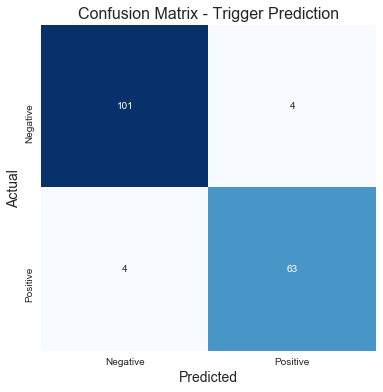

In [97]:
# Plot our confusion matrix
plt.figure(figsize = (6,6))
ax = plt.subplot()
sns.heatmap(cm_test, 
            annot=True, 
            ax = ax, 
            fmt='g', 
            cbar=False,
            cmap="Blues"); #annot=True to annotate cells

# labels, title and ticks
ax.set_title('Confusion Matrix - Trigger Prediction', size=16)
ax.set_xlabel('Predicted', size=14)
ax.set_ylabel('Actual', size=14)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive']);

In [98]:
# Setting up probabilities for the ROC curve
pred_proba = results_cvec.predict_proba(X_test)
preds = results_cvec.predict(X_test)

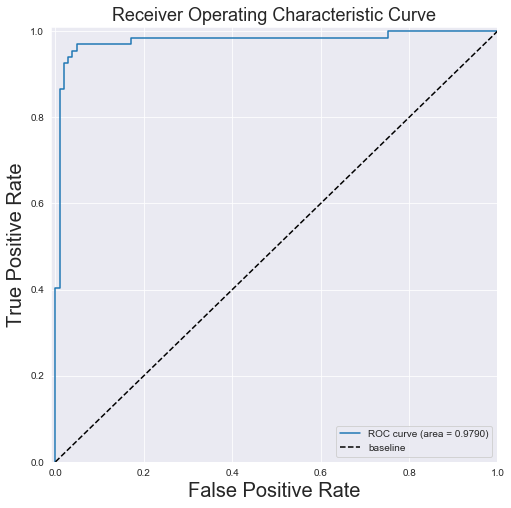

In [99]:
fpr, tpr, _= roc_curve(y_test, pred_proba[:,1])
roc_auc = auc(fpr, tpr)
# Plot of a ROC curve for a specific class
plt.figure(figsize = (8,8))
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='baseline')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate', fontsize =20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.title('Receiver Operating Characteristic Curve', fontsize=18)
plt.legend(loc="lower right");

In [100]:
# To allow us to better read the Sentences
pd.set_option('display.max_colwidth', None)

In [101]:
result_cols = ['prediction', 'actual', 'Sentence']
results = pd.DataFrame({'prediction': list(preds), 'actual': list(y_test), 'Sentence': list(X_test)})


,prediction,actual,Sentence
0,0,0,“Mezzanine Loan Default” means an “Event of Default” under the Mezzanine Loan documents.
1,0,0,"Provided that no Mortgage Loan Event of Default is continuing, the lender will release to the Borrowers’ operating account all amounts then contained in the Excess Cash Flow Reserve Account on the first Payment Date following termination of a Cash Sweep Period."
2,0,0,"Mortgage Lender will disburse to the Borrower the Leasing Reserve Funds upon satisfaction by the Borrower of each of the following conditions: (i) the Borrower will submit a request for payment to Mortgage Lender at least 10 Business Days prior to the date on which the Borrower requests such payment be made and specifies the Approved Leasing Costs to be paid; (ii) on the date such request is received by Mortgage Lender and on the date such payment is to be made, no Mortgage Loan Event of Default will exist and remain uncured; and (iii) Mortgage Lender will have received a certificate from the Borrower stating either that such tenant improvement payment is required to be paid to the tenant under its Lease or, otherwise, (A) stating that the items to be funded by the requested disbursement are Approved Leasing Costs, (B) stating to the Borrower’s knowledge, that all tenant improvements at the Property to be funded by the requested disbursement have been completed (or completed to the extent of the requested disbursement) in good and workmanlike manner and in accordance with all applicable federal, state and local laws, rules and regulations, and (C) stating that each Person that supplied materials or labor in connection with the tenant improvements to be funded by the requested disbursement has been paid in full for work completed through such date or will be paid in full upon such disbursement (or if progress payments are being made, that such Person has been or will be paid all amounts owed to them based on the work such Person has completed); (iv) at Mortgage Lender’s option, if the amount of any individual disbursement of Leasing Reserve Funds exceeds $250,000, a title search for the Property indicating that the Property is free from all liens, claims and other encumbrances not previously approved by Mortgage Lender; and (v) Mortgage Lender will have received such other evidence as Mortgage Lender will reasonably request that the Approved Leasing Costs to be funded by the requested disbursement have been completed (to the extent applicable), are due and payable and are paid for or will be paid upon such disbursement to the Borrower."
3,0,0,"A “Trigger Period” will commence upon the occurrence of (i) an event of default, (ii) a low debt yield trigger period or (iii) the commencement of an event of default under the Mezzanine Loan; and will end if, (A) with respect to a Trigger Period continuing pursuant to clause (i), the event of default commencing the Trigger Period has been cured and such cure has been accepted by the lender (and no other event of default is then continuing), (B) with respect to a Trigger Period continuing pursuant to clause (ii), the low debt yield trigger period has ended or (C) with respect to a Trigger Period continuing pursuant to clause (iii), receipt by the lender of a mezzanine loan default revocation notice."
4,0,0,"“Low Cash Flow Period” means a period: (a) commencing upon the Debt Yield (tested quarterly) falling below (A) six percent (6.0%) during the initial term of the Whole Loan or the first, second or third Extension Period or (B) six and one-half percent (6.50%) during the fourth or fifth Extension Period, in each case for any two (2) consecutive fiscal quarters; and (b) expiring upon the date that the Debt Yield (tested quarterly) is equal to or greater than (A) six percent (6.00%) during the initial term of the Whole Loan or the first, second or third Extension Period or (B) six and one-half percent (6.50%) during the fourth or fifth Extension Period, in each case for any two (2) consecutive fis

In [102]:
misclassified = results[results['prediction'] != results['actual']]


In [103]:
misclassified.head(10)

,prediction,actual,Sentence
19,1,0,"During the continuance of a Cash Management Period (other than one caused by an Event of Default), the Cash Management Bank will be required to withdraw all available funds on deposit in the Cash Management Account on each Business Day and disburse such funds in the following amounts and order of priority: (i) first, to the tax subaccount of the Cash Management Account, an amount sufficient to fund the required monthly deposit for payment of taxes; (ii) second, unless the Property is covered by a blanket insurance policy, to the insurance subaccount of the Cash Management Account, an amount sufficient to fund the required monthly deposit for payment of insurance premiums; (iii) third, to the debt service subaccount of the Cash Management Account, the amount of any interest accruing at the Default Rate and late payment charges; (iv) fourth, to the debt service subaccount of the Cash Management Account, the monthly debt service amount (provided during the Extension Term this shall only be the interest calculated at the Initial Interest Rate and the Initial B Note Interest Rate); (v) fifth, to the Cash Management Bank, the Cash Management Bank’s fees; (vi) sixth, during a Cash Trap Period (and at all times during the Extension Term), to the Borrowers, an amount equal to the operating expenses reasonably approved by the Lender for the month in which such Loan Payment Date occurs; (vii) seventh, to the capital expenditure subaccount of the Cash Management Account, a monthly amount equal to $24,369.30; (viii) eighth, to the rollover subaccount of the Cash Management Account, a monthly amount equal to $182,770.75; (ix) ninth, other than during the Extension Term, during a Cash Trap Period, to the excess cash flow account, all amounts remaining in the Cash Management Account after deposits for items (i) through (vii) above; (x) tenth, other than during the Extension Term, provided a Cash Trap Period is not then continuing, all amounts remaining in the Cash Management Account after deposits for items (i) through (ix) above will be disbursed to the Borrowers; (xi) eleventh, during the Extension Term, funds sufficient to pay the remaining portion of the monthly debt service amount; (xii) twelfth, during the Extension Term, all amounts remaining in the Cash Management Account after deposits for items (i) through (xi) above (the “Available Cash Flow”) shall pay any outstanding Excess Interest then due and payable; and (xiii) thirteenth, during the Extension Term, all amounts remaining in the Cash Management Account after deposits for items (i) through (xii) above shall be applied to repay the outstanding principal balance of the Whole Loan on a pari passu basis."
52,0,1,"On each Mortgage Loan Payment Date during the continuance of a Cash Sweep Period, the Borrower must pay to the Mortgage Lender one-twelfth of the rents (including both base and additional rents) and other charges due under each Ground Lease that the Mortgage Lender estimates will be payable by the Borrower as lessee under the related Ground Lease (the account into which such funds are deposited, the “Ground Lease Reserve Account”) during the ensuing twelve (12) months in order to accumulate with the Mortgage Lender sufficient funds to pay all such ground rent at least thirty (30) days prior to the respective due dates, provided that, to the extent ground rent is reserved for in the Manager Reserve Account maintained by the Property Manager pursuant to the Management Agreement (or an Approved Replacement Manager pursuant to an Approved Replacement Management Agreement) or is timely paid by the Property Manager pursuant to the Management Agreement (or an Approved Replacement Manager pursuant to an Approved Replacement Management Agreement) and the Borrower delivers to the Mortgage Lender evidence reasonably acceptable to the Mortgage Lender that such Property Manager is holding such funds and making the required payments of ground rent in 